In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go

torch.set_default_dtype(torch.float64)

c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # # Generating inital values for Wall slip parameters

# # #tau_w_range = [0.001, 1] 0.001 , 2
# # # #m_range = [0.5, 2]     0.1 , 2,5

lower= [0.001, 0.1]
upper = [1.0, 1.9]

# sampler = qmc.LatinHypercube(d=2)
# sample = sampler.random(5)

# scaled_values = qmc.scale(sample, lower, upper)
# tau_w_values = scaled_values[:,0]
# m_values = scaled_values[:,1]
# plt.scatter(tau_w_values, m_values)
# plt.show()

# LHS_data = pd.DataFrame({
#     'tau_w_values': tau_w_values,
#     'm_values': m_values
# })
# LHS_data.to_csv('tau_w_and_m_values.csv', index=False)

In [3]:
def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)

    # Resample both curves on this time grid
    real_disp_resampled = np.interp(common_time, real_time, real_disp)
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    mse = np.mean((real_disp_resampled-guess_disp_resampled)**2)
    
    return mse

file_directory = Path("H:\\XMLFiles")
real_data_directory = "H:\\Real_data\\press_force_real.xml"
areas = []
area_data = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []
guess_data_all = {}

count = 0

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    if count >=  27:
        break  # Stop the loop after collecting 40 values

    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

    count += 1

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1] * 0.0001019716




In [4]:

df = pd.read_csv('tau_w_and_m_values.csv')


tau_w_values = df['tau_w_values'].tolist()
m_values = df['m_values'].tolist()


In [5]:
#Synergy = win32com.client.Dispatch("synergy.Synergy")
#Synergy.SetUnits("Metric")
#moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"                        #Home D:\\Moldflow Insight 2023\\bin       #WS "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"  #"G:\\Oskay Sözen\\wall_slip\\wall slip.mpi"


#Synergy.OpenProject("G:\\Oskay Sözen\\slip\\slip.mpi")
#Project = Synergy.Project
#Project.OpenItemByName("50SurfaceCoverage_study css0.01 m 1.5", "Study")



# Simulation loop for wall slip parameters
# for i in range(5):

#     tau_w = tau_w_values[i]
#     m = m_values[i]
#     print(f"Simulation {i+1} with tau_w : {tau_w} and m: {m}")

#     study_name =f"study_force_{i+1}"
#     Project = Synergy.Project
    
#     PropEd = Synergy.PropertyEditor
#     Prop = PropEd.FindProperty(10090, 1)
#     DVec = Synergy.CreateDoubleArray
    
#     DVec.AddDouble(tau_w)
#     DVec.AddDouble(m)
#     DVec.AddDouble(1e-08)
#     DVec.AddDouble(0)
#     DVec.AddDouble(0)
    
#     Prop.FieldValues(51182, DVec)
        
#     PropEd.CommitChanges("Process Conditions")

#     StudyDoc = Synergy.StudyDoc
#     StudyDoc.SaveAs(study_name)

#     p = subprocess.Popen(
#     [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\slip\\study_force_{i+1}.sdy"],
#     stdout=subprocess.PIPE,
#     stderr=subprocess.STDOUT,
#     )
#     (output, err) = p.communicate()
    

#     time.sleep(10)
    
#     # Restart of the Synergy to prevent XML saving crash
    
#     subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

#     time.sleep(10)

#     Synergy.OpenProject("G:\\Oskay Sözen\\slip\\slip.mpi")
#     Project = Synergy.Project
#     Project.OpenItemByName(f"study_force_{i+1}", "Study")


#     PlotMgr = Synergy.PlotManager
#     time.sleep(10)
#     Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
#     Pid = Plot.GetDataID
#     PlotMgr = None
#     PlotMgr = Synergy.PlotManager
#     time.sleep(10)
#     PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\study_force_{i + 1}.xml", "Metric")
    
    


    
# # Write the output to a log file
#     with open(f"H:\\Log_Files\\study_force_{i+1}.log", "w") as file:
#         file.write(output.decode("windows-1252").strip())

In [6]:
## CAREFUL ONLY APPEND 1 TIME
valid_xml = []
for i in range(5):
        guess_tree = ET.parse(f"H:\\XMLFiles\\study_force_{i + 1}.xml")
        guess_root = guess_tree.getroot()
        guess_data = []

        count = 0
                
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
                if count >= 27:
                        break


                time_value = time_block.attrib.get('Value')
                dept_value = dept_block.find('DeptValues').text.strip()
                guess_data.append((time_value, dept_value))

                count += 1
        if len(guess_data) < 27:
                print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
                continue

        guess_data_all[f"guess_data_{i+1}"] = guess_data

        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1]

        globals()[f"guess_time_{i+1}"] = guess_time
        globals()[f"guess_disp_{i+1}"] = guess_disp


        mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
        area_data.append(mean_s_error)
        valid_xml.append(len(area_data) - 1)

        
print(guess_data_all)


{'guess_data_1': [('0.019225', '4.2229e+00'), ('0.105600', '5.3796e+00'), ('0.136271', '1.0377e+01'), ('0.195790', '1.8011e+01'), ('0.252516', '1.9947e+01'), ('0.314471', '2.1411e+01'), ('0.361478', '2.3640e+01'), ('0.424437', '2.5721e+01'), ('0.473875', '2.8206e+01'), ('0.520261', '3.0530e+01'), ('0.576031', '3.2425e+01'), ('0.622701', '3.5019e+01'), ('0.690657', '3.6872e+01'), ('0.779302', '3.9323e+01'), ('0.855361', '4.2320e+01'), ('0.952287', '4.4874e+01'), ('1.033005', '4.7976e+01'), ('1.153061', '5.0243e+01'), ('1.262885', '5.3486e+01'), ('1.411248', '5.5527e+01'), ('1.549840', '5.8371e+01'), ('1.782413', '6.0391e+01'), ('2.013549', '6.8971e+01'), ('2.348015', '7.8480e+01'), ('2.693953', '9.3076e+01'), ('2.978196', '1.1004e+02'), ('3.251858', '1.2644e+02')], 'guess_data_2': [('0.019225', '4.2633e+00'), ('0.105600', '5.3769e+00'), ('0.136100', '1.0360e+01'), ('0.195682', '1.7997e+01'), ('0.252418', '1.9955e+01'), ('0.313630', '2.1408e+01'), ('0.363950', '2.3601e+01'), ('0.420126',

In [7]:
print(real_disp)
print(area_data)

[ 3.58205836  4.0856961   8.30986963 11.044544    8.54827923  7.79807417
  7.75065737  6.9423285   6.15306832  5.87550162  5.53206127  5.16353591
  4.09793269  4.20867385  4.08987693  3.96781693  3.82668823  3.9018413
  4.08620596  4.45309977  4.85904871  4.83447356  5.78219761  5.25429063
  7.10221997  9.22690023 12.41912116]
[np.float64(5015.377920371384), np.float64(5096.254871392336), np.float64(4920.536965771151), np.float64(5246.793125755007), np.float64(3.710464953570179)]


In [8]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[np.float64(5015.377920371384), np.float64(5096.254871392336), np.float64(4920.536965771151), np.float64(5246.793125755007), np.float64(3.710464953570179)]
['guess_data_1', 'guess_data_2', 'guess_data_3', 'guess_data_4', 'guess_data_5']
guess_data_1: Shape = (27, 2)
guess_data_2: Shape = (27, 2)
guess_data_3: Shape = (27, 2)
guess_data_4: Shape = (27, 2)
guess_data_5: Shape = (27, 2)


In [9]:
file_path = 'H:\\moldflow\\moldflow_automation\\tau_w_and_m_values.csv'  
data = pd.read_csv(file_path)
tau_w_values = data['tau_w_values'].values
m_values = data['m_values'].values
area_data_optimization = []
train_x = torch.tensor([[tau_w_values[i], m_values[i]] for i in valid_xml], dtype=torch.float64)
train_y = -torch.tensor([[area_data[i]] for i in valid_xml], dtype=torch.float64)
scale_factor = 1
train_y_scaled = train_y * scale_factor
train_yvar = torch.full_like(train_y_scaled, 1e-6)

# #tau_w_range = [0.001, 1] 0.001 , 2
# # #m_range = [0.5, 2]     0.1 , 2,5
# lower= [0.1, 1.0]
# upper = [5.0, 2.0]

# lower= [0.0001, 0.01]
# upper = [0.1, 1.0]

bounds = torch.tensor([
    [0.001, 0.1], 
    [1.0, 1.9]    
], dtype=torch.float64
)

outcome_transform = Standardize(m=1)
input_transform = Normalize(d=2)

# Optimization
model = SingleTaskGP(train_x, train_y_scaled,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
model.eval()    

acq_func =  LogExpectedImprovement(model, best_f=train_y_scaled.max().item())
# acq_func =  qLogExpectedImprovement(model, best_f=train_y.max())

candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=1000, #Helps to ensure that we find the global optimum instead of finding the local optimum
        raw_samples=5000,  #More samples increases likelihood of finding good starting point.
)

cand = model(input_transform(candidate))
cand_var = torch.diagonal(cand.covariance_matrix, 0)
cand_mean, cand_std = outcome_transform.untransform(cand.mean, cand_var)

c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


In [10]:
print(candidate)
print(train_y_scaled)
print(train_x)
bounds.shape

tensor([[0.0010, 0.2989]])
tensor([[-5.0154e+03],
        [-5.0963e+03],
        [-4.9205e+03],
        [-5.2468e+03],
        [-3.7105e+00]])
tensor([[0.7713, 0.6080],
        [0.5567, 1.0239],
        [0.8045, 0.2226],
        [0.3877, 1.7984],
        [0.0606, 1.4646]])


torch.Size([2, 2])

In [11]:
with torch.no_grad():
    #Generate grid for plotting
    x_grid, y_grid = np.meshgrid(
        np.linspace(bounds[0, 0].item(), bounds[1, 0].item(), 50),
        np.linspace(bounds[0, 1].item(), bounds[1, 1].item(), 50),
    )
    val_X_grid_tensor = torch.tensor(
        np.column_stack((x_grid.ravel(), y_grid.ravel())),
        dtype=torch.float64,
    )
    #plt.scatter(x_grid, y_grid)
    #plt.show()
    val_X_grid_tensor = input_transform(val_X_grid_tensor)

    #GP predictions on the grid
    pred_Y = model(val_X_grid_tensor)
    pred_Yvar = torch.diagonal(pred_Y.covariance_matrix, 0)
    pred_mean, pred_var = outcome_transform.untransform(pred_Y.mean, pred_Yvar)
    #pred_mean = pred_Y.mean
    #pred_var = pred_Yvar
    pred_mean = pred_mean.detach().numpy().reshape(x_grid.shape)
    pred_std = torch.sqrt(pred_var).detach().numpy().reshape(x_grid.shape)
    


# Check if the unit conversions are right from moldflow export

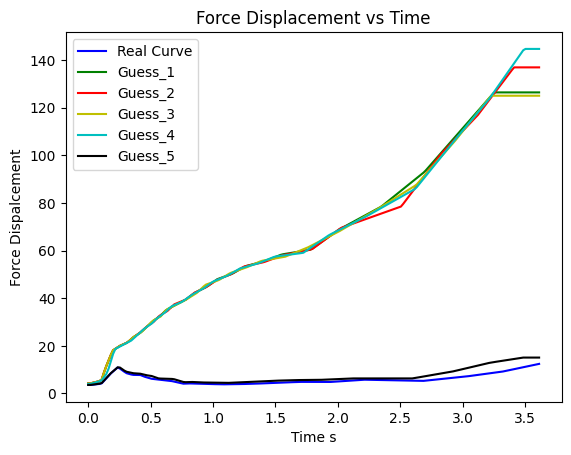

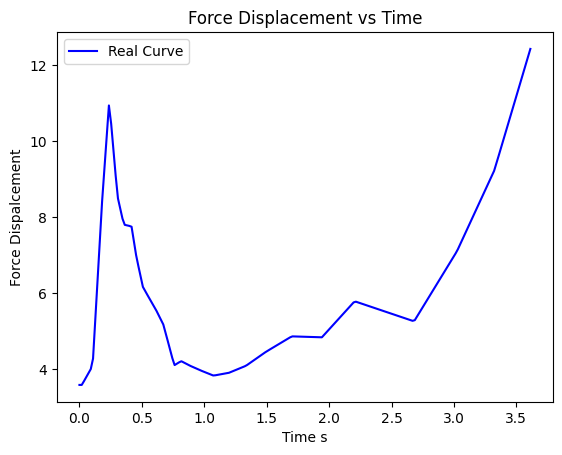

In [12]:
common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)
real_disp_resampled = np.interp(common_time, real_time, real_disp)
guess_1_disp_resampled = np.interp(common_time, guess_time_1, guess_disp_1)
guess_2_disp_resampled = np.interp(common_time, guess_time_2, guess_disp_2)
guess_3_disp_resampled = np.interp(common_time, guess_time_3, guess_disp_3)
guess_4_disp_resampled = np.interp(common_time, guess_time_4, guess_disp_4)
guess_5_disp_resampled = np.interp(common_time, guess_time_5, guess_disp_5)
plt.plot(common_time, real_disp_resampled, 'b-', label = 'Real Curve')
plt.plot(common_time, guess_1_disp_resampled, 'g-',label = 'Guess_1' )
plt.plot(common_time, guess_2_disp_resampled, 'r-',label = 'Guess_2' )
plt.plot(common_time, guess_3_disp_resampled, 'y-',label = 'Guess_3' )
plt.plot(common_time, guess_4_disp_resampled, 'c-',label = 'Guess_4' )
plt.plot(common_time, guess_5_disp_resampled, 'k-',label = 'Guess_5' )
plt.legend(loc='best')
plt.xlabel('Time s')
plt.ylabel('Force Dispalcement')
# plt.ylim(1.84 ,1.88)
plt.title('Force Displacement vs Time')
plt.show()
plt.plot(common_time, real_disp_resampled, 'b-', label = 'Real Curve')
plt.legend(loc='best')
plt.xlabel('Time s')
plt.ylabel('Force Dispalcement')
plt.title('Force Displacement vs Time')
plt.show()


In [13]:
fig = go.Figure()



fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean,
    colorscale='Viridis', opacity=0.6, name="GP Mean"
))


fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean + pred_std,
    colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean + Std"
))


fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean - pred_std,
    colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean - Std"
))


fig.add_trace(go.Scatter3d(
    x=train_x[:, 0].numpy(),
    y=train_x[:, 1].numpy(),
    z=train_y_scaled.flatten().numpy(),
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Training Data'
))

fig.add_trace(go.Scatter3d(
    x=[0.01],
    y=[1.5],
    z=[0],
    mode='markers',
    marker=dict(size=8, color='blue'),
    name='Ground truth'
)
)

for i in range(candidate.shape[0]):  
    
    cand = model(input_transform(candidate[i].unsqueeze(0)))
    cand_var = torch.diagonal(cand.covariance_matrix, 0)
    cand_mean, _ = outcome_transform.untransform(cand.mean, cand_var)
    
    
    fig.add_trace(go.Scatter3d(
        x=[candidate[i, 0].item()],
        y=[candidate[i, 1].item()],
        z=[cand_mean.item()],
        mode='markers',
        marker=dict(size=8, color='red'),
        name=f'Candidate {i + 1}'
    ))


fig.update_layout(
    scene=dict(
        xaxis_title="Critical shear stress (Tau_W)",
        yaxis_title="Slip exponent (m)",
        zaxis_title="Predicted Value (mse)"
        
        
    ),
    title="Interactive GP Model Predictions with Uncertainty and Candidates",
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()
# fig.write_html("gp_model_predictions.html")


In [16]:

tau_w_range = torch.linspace(bounds[0, 0], bounds[1, 0], 100)  # Grid for tau_w
m_range = torch.linspace(bounds[0, 1], bounds[1, 1], 100)      # Grid for m
tau_w_grid, m_grid = torch.meshgrid(tau_w_range, m_range, indexing="ij")


grid = torch.stack([tau_w_grid.ravel(), m_grid.ravel()], dim=-1)


acq_values = torch.exp(acq_func(grid.unsqueeze(1))).detach().numpy().reshape(100, 100)


train_acq_values = torch.exp(acq_func(train_x.unsqueeze(1))).detach().numpy()

acq_min = acq_values.min()
acq_max = acq_values.max()
acq_values_norm = (acq_values - acq_min) / (acq_max - acq_min)
train_acq_values_norm = (train_acq_values - acq_min) / (acq_max - acq_min)
candidate_acq_value = acq_func(candidate[i].unsqueeze(0)).item()
candidate_acq_value_norm = (candidate_acq_value - acq_min) / (acq_max - acq_min)

fig = go.Figure()


fig.add_trace(go.Surface(
    x=tau_w_grid.numpy(),
    y=m_grid.numpy(),
    z=acq_values_norm,
    colorscale='Viridis',
    opacity=0.6,
    name="Acquisition Function"
))


fig.add_trace(go.Scatter3d(
    x=train_x[:, 0].numpy(),
    y=train_x[:, 1].numpy(),
    z=train_acq_values_norm.flatten(),
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Training Data'

))

fig.add_trace(go.Scatter3d(
    x=[0.01],
    y=[1.5],
    z=[acq_values.max()] ,
    mode='markers',
    marker=dict(size=8, color='blue'),
    name='Ground truth'
)
)

#Iterate over the candidates
for i in range(candidate.shape[0]): 
    candidate_acq_value = acq_func(candidate[i].unsqueeze(0)).item()
    fig.add_trace(go.Scatter3d(
        x=[candidate[i, 0].item()],
        y=[candidate[i, 1].item()],
        z=[candidate_acq_value_norm],
        mode='markers',
        marker=dict(size=8, color='red', symbol='circle'),
        name=f'Candidate {i + 1}'
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="Critical shear stress (Tau_W)",
        yaxis_title="Slip exponent (m)",
        zaxis_title="Acquisition Value",
        zaxis=dict(title="Acquisition Value", range=[0,1])
    ),
    title="Interactive Acquisition Function",
    margin=dict(l=0, r=0, b=0, t=40)
)


fig.show()
# fig.write_html("acquisiton_func.html")


In [15]:
print("acq_values range:", acq_values.min(), acq_values.max())

acq_values range: -1017333.674807471 6.041602729006631


In [ ]:
# Optimization
guess_data_all_optim = {}
num_iteration = 8
iterations=[]
#tolerance = 1e-12

for i in range(num_iteration):
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=2)
    #  Optimization
    model = SingleTaskGP(train_x, train_y_scaled,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()    

    acq_func =  LogExpectedImprovement(model, best_f=train_y_scaled.max())
    # acq_func =  qLogExpectedImprovement(model, best_f=train_y.max())

    candidate_optim, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts=1000, #Helps to ensure that we find the global optimum instead of finding the local optimum
            raw_samples=5000,  #More samples increases likelihood of finding good starting point.
    )    

    print(f"Iteration {i+1}: Suggested new parameters (tau_w, m)", candidate_optim)
    iterations.append(candidate_optim)

    study_name = f"optimization_forceee_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(candidate_optim[0,0].item())
    DVec.AddDouble(candidate_optim[0,1].item())
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")
    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)
    
    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\slip\\optimization_forceee_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    

    time.sleep(3)
    
    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(3)

    Synergy.OpenProject("G:\\Oskay Sözen\\slip\\slip.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"optimization_forceee_{i+1}", "Study")
    PlotMgr = Synergy.PlotManager
    time.sleep(3)
    Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(3)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\optimization_forceee_{i + 1}.xml", "Metric")
    


    guess_tree = ET.parse(f"H:\\XMLFiles\\optimization_forceee_{i+1}.xml")
    guess_root = guess_tree.getroot()
    guess_data = []
    time.sleep(3) 
    count = 0   
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
        if count >= 30:
            break
        
        time_value = time_block.attrib.get('Value')
        dept_value = dept_block.find('DeptValues').text.strip()
        guess_data.append((time_value, dept_value))

        count += 1
    if len(guess_data) < 30:
        print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
        continue
    guess_data_all_optim[f"guess_data_{i+1}"] = guess_data

    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]  
    guess_disp = guess_data_array[:, 1]  
        
    globals()[f"guess_time_{19 + num_iteration}"] = guess_time
    globals()[f"guess_disp_{19 + num_iteration}"] = guess_disp
    
    mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
    area_data.append(mean_s_error)
    valid_xml.append(len(area_data) - 1)
    
    
    #GP predictions on the grid
    pred_Y = model(val_X_grid_tensor)
    pred_Yvar = torch.diagonal(pred_Y.covariance_matrix, 0)
    pred_mean, pred_var = outcome_transform.untransform(pred_Y.mean, pred_Yvar)
    #pred_mean = pred_Y.mean
    #pred_var = pred_Yvar
    pred_mean = pred_mean.detach().numpy().reshape(x_grid.shape)
    pred_std = torch.sqrt(pred_var).detach().numpy().reshape(x_grid.shape)


    fig = go.Figure()



    fig.add_trace(go.Surface(
        x=x_grid, y=y_grid, z=pred_mean,
        colorscale='Viridis', opacity=0.6, name="GP Mean"
    ))


    fig.add_trace(go.Surface(
        x=x_grid, y=y_grid, z=pred_mean + pred_std,
        colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean + Std"
    ))


    fig.add_trace(go.Surface(
        x=x_grid, y=y_grid, z=pred_mean - pred_std,
        colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean - Std"
    ))


    fig.add_trace(go.Scatter3d(
        x=train_x[:, 0].numpy(),
        y=train_x[:, 1].numpy(),
        z=train_y_scaled.flatten().numpy(),
        mode='markers',
        marker=dict(size=8, color='black'),
        name=f"Optimization_{i+1}"
    ))

    fig.add_trace(go.Scatter3d(
        x=[0.01],
        y=[1.5],
        z=[0],
        mode='markers',
        marker=dict(size=8, color='blue'),
        name='Ground truth'
    )
    ) 
        
    cand = model(input_transform(candidate_optim.unsqueeze(0)))
    cand_var = torch.diagonal(cand.covariance_matrix, 0)
    cand_mean, _ = outcome_transform.untransform(cand.mean, cand_var)
    
    
    fig.add_trace(go.Scatter3d(
        x=[candidate_optim[0,0].item()],
        y=[candidate_optim[0,1].item()],
        z=[cand_mean.item()],
        mode='markers',
        marker=dict(size=8, color='red'),
        name=f'Candidate {i + 1}'
    ))


    fig.update_layout(
        scene=dict(
            xaxis_title="Critical shear stress (Tau_W)",
            yaxis_title="Slip exponent (m)",
            zaxis_title="Predicted Value (mse)"
            
            
        ),
        title="Interactive GP Model Predictions with Uncertainty and Candidates",
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # Show the plot
    fig.show()
    fig.write_html(f"H:\\Plots\\gp_model_force_predictions_{i+1}.html")



    
# Write the output to a log file
    with open(f"H:\\Log_Files\\optimization_forceee_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

    train_x = torch.cat([train_x, candidate_optim], dim=0)
    train_y_scaled = torch.cat([train_y_scaled, -torch.tensor([[area_data[-1]]])*scale_factor], dim=0)
    train_yvar = torch.full_like(train_y_scaled, 1e-6)
    # new_noise_var = torch.tensor([1e-6])
    # train_yvar = torch.cat([train_yvar, new_noise_var], dim=0)
    current_best_area = train_y_scaled.max().item()   # Needs to be revised because train_y values are negative now

    if abs(current_best_area) < 1e-2:
        print(f"Converged after {i+1} iteration")
        break

    

best_params = train_x[train_y_scaled.argmax()]
best_area = train_y_scaled.max().item()
print(f"Best parameters (tau_w, m): {best_params}, with MSE : {best_area}")

c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



Iteration 1: Suggested new parameters (tau_w, m) tensor([[0.0010, 0.2988]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



Iteration 2: Suggested new parameters (tau_w, m) tensor([[0.0042, 1.6861]])


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



Iteration 3: Suggested new parameters (tau_w, m) tensor([[1.0000e-03, 1.4503e+00]])


In [ ]:


common_time = np.linspace(0.0, real_time.max(), num=200)
real_disp_resampled = np.interp(common_time, real_time, real_disp)


plt.plot(common_time, real_disp_resampled, 'b-', label='Real Curve')


colors = ['g-', 'r-', 'y-', 'c-', 'k-', 'm-', 'orange', 'purple', 'brown', 'teal']

for i, (key, guess_data) in enumerate(guess_data_all_optim.items(), start=1):
    
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]
    
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)
    
    
    plt.plot(common_time, guess_disp_resampled, colors[(i - 1) % len(colors)], label=f'Guess_{i}')


plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Force Displacement')
plt.title('Force Displacement vs Time (Optimized Curves)')
plt.grid(True)
plt.show()





In [ ]:
print(train_y_scaled)
print(train_x)
print(area_data)


# Some xml files are corrupted and feeded into the optimization, make a if statement to detect and avoid these faulty xml files

In [ ]:
for i, (key, guess_data) in enumerate(guess_data_all_optim.items(), start=1):
   
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]

    
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)
    
    
    plt.plot(common_time, guess_disp_resampled, colors[(i - 1) % len(colors)], label=f'Guess_{i}')


real_disp_resampled = np.interp(common_time, real_time, real_disp)


plt.plot(common_time, real_disp_resampled, 'b-', label='Real Curve')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Force Displacement')
plt.title('Force Displacement vs Time (Optimized Curves)')
plt.grid(True)
plt.show()


In [ ]:
for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
   
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]

    
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)
    
    
    plt.plot(common_time, guess_disp_resampled, colors[(i - 1) % len(colors)], label=f'Guess_{i}')


real_disp_resampled = np.interp(common_time, real_time, real_disp)


plt.plot(common_time, real_disp_resampled, 'b-', label='Real Curve')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Force Displacement')
plt.title('Force Displacement vs Time (5 Random Guess Curves)')
plt.grid(True)
plt.show()